In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from mude_tools import neuralnetplotter
from mude_tools import draw_neural_net
from sklearn.neural_network import MLPRegressor
# use "%matplotlib widget" if on jupyter-lab, or "%matplotlib nbagg" if on jupyter-notebook
# %matplotlib nbagg
%matplotlib widget

## Introduction

Recall that in the previous notebooks we have applied linear models with basis functions
$$ y(x,\mathbf{w}) = \sum_{j=0}^M w_j \phi_j(x) = \mathbf{w}^T \boldsymbol{\phi} (x).$$

Here $\mathbf{w}$ are the flexible parameters, and $\boldsymbol{\phi}$ the basis functions.

Because a linear model is linear to its parameters $\mathbf{w}$, we could solve for $\bar{\mathbf{w}}$ directly

$$ \bar{\mathbf{w}} = \big( \boldsymbol{\Phi}^T \boldsymbol{\Phi} \big)^{-1} \boldsymbol{\Phi}^T \mathbf{t}.$$

When the data to be described is complex, relying on pre-defined basis functions might not give sufficient accuracy. To overcome this, a more flexible model is required. This can be achieved by replacing the basis functions with parametric functions, in this notebook we will dive into one of these, namely neural networks. The underlying problem will stay the same, where we are trying to learn the underlying relation of a (noisy) process based on a limited number of observations $\mathcal{D}=\{\mathbf{x}, \mathbf{t}\}$ from that process. Similarly, we are trying to minimize the mean squared error loss function
$$L =  \frac{1}{N} \sum_{n=1}^N \big(t_n - y(x_n, \mathbf{w}) \big)^2 $$  <!--- \dfrac{1}{2N} -->
where $y(x, \mathbf{w})$ now represents a neural network.

In [2]:
# The true function relating t to x
def f_truth(x, freq=2, **kwargs):

    # Return a sine with a frequency of f
    return np.sin(x * freq)

# The data generation function
def f_data(epsilon=0.7, N=100, **kwargs):

    # Apply a seed if one is given
    if 'seed' in kwargs:
        np.random.seed(kwargs['seed'])

    # Get the minimum and maximum
    xmin = kwargs.get('xmin', 0)
    xmax = kwargs.get('xmax', 2*np.pi)

    # Generate N evenly spaced observation locations
    x = np.linspace(xmin, xmax, N)

    # Generate N noisy observations (1 at each location)
    t = f_truth(x, **kwargs) + np.random.normal(0, epsilon, N)

    # Return both the locations and the observations
    return x, t

## Neural network architecture
A neural network consists of neurons connected by weights, with information flowing from input nodes towards output nodes. The states of the input and output nodes are known during training. There are additional nodes in layers in between the inputs and outputs, these are known as hidden nodes. Nodes are separated into layers, where all nodes in one layer depend on the nodes in the previous layer.
The state of a neuron is determined by a linear combination of states $z$ from the previous layer with their connecting weights $w$
$$ a^{(l)}_{j} = \sum_{i}^{D} w_{ji}^{(l)} z_{i}^{(l-1)} + w_{j0}^{(l)}  $$
followed by a nonlinear transformation with an activation function:
$$ z^{(l)}_{j} = h(a^{(l)}_{j}).  $$

Plotted here are the identity (or linear), sigmoid, hyperbolic tangent (tanh), and rectified linear unit (relu) activation functions.

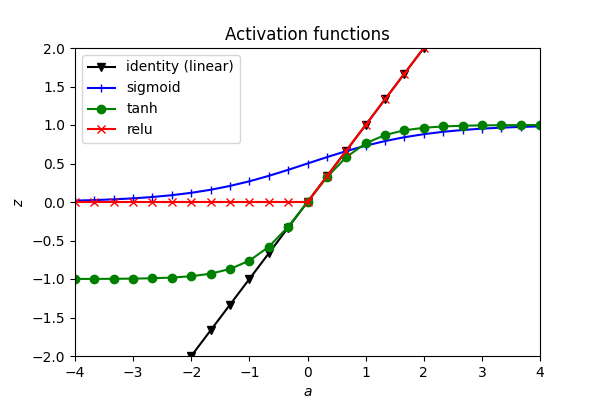

In [3]:
x = np.linspace(-4, 4, 25)

# Compute activation functions
identity = x
sigmoid = [1/(1+np.exp(-x)) for x in x]
tanh = np.tanh(x)
relu = [max(0, x) for x in x]

# Plot figure
plt.figure(figsize=(6,4))
plt.plot(x, identity, 'k-v',label='identity (linear)')
plt.plot(x, sigmoid, 'b-|',label='sigmoid')
plt.plot(x, tanh, 'g-o',label='tanh')
plt.plot(x, relu, 'r-x', label='relu') # c='red', linestyle=(0, (20, 30)),label='relu')
plt.xlim(-4, 4)
plt.ylim(-2, 2)
plt.xlabel('$a$')
plt.ylabel('$z$')
plt.title('Activation functions')
plt.legend()
plt.show()


The number of layers in a neural network commonly refers to the number of hidden layers. The formulation of a two-layer neural network is thus:


$$ y(x, \mathbf{w}) = h^{(out)} \left( \sum_{p=0}^{Q} w_{pk}^{(3)} h^{(2)} \big( \sum_{j=0}^{M} w_{kj}^{(2)} h^{(1)} ( \sum_{i=0}^{D} w_{ji}^{(1)} x_i ) \big) \right) $$
With the nonlinear activation functions, this is evidently no longer linear to the weights, and in general, no closed-form solution can be found. Instead, a form of gradient descent, as discussed in the previous notebook, is required to minimize a loss function by changing the weights.

When your dataset contains multiple inputs or outputs, this model can easily be extended by including multiple nodes in the input or output layer, the other procedures stay the same. Generally, the activation function of the outputs $h^{(out)}$ is linear, the activations in hidden nodes are of a nonlinear type.

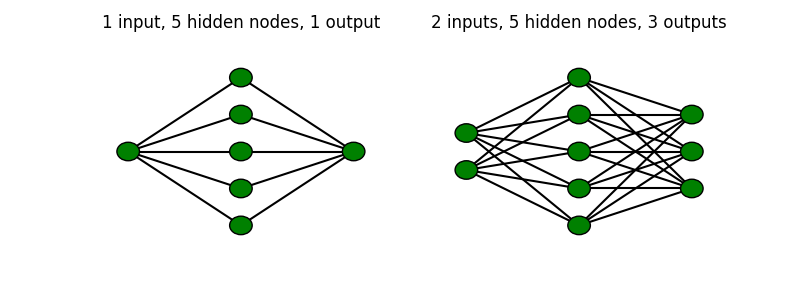

In [4]:
f = plt.figure(figsize=(8,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
draw_neural_net(ax, .1, .9, .1, .9, [1, 5, 1])
ax.set_title('1 input, 5 hidden nodes, 1 output')
draw_neural_net(ax2, .1, .9, .1, .9, [2, 5, 3])
ax2.set_title('2 inputs, 5 hidden nodes, 3 outputs')
ax.axis('off')
ax2.axis('off')
plt.show()


# Model flexibility
The number of nodes in a hidden layer, and the number of hidden layers, can be varied to change the flexibility of a neural network.
The flexibility of a neural network can be adapted by varying the number of nodes in a hidden layer, or by adding several hidden layers. Both increase the number of parameters $\mathbf{w}$. When a neural network has few parameters, it generally leads to an underfit result, whereas having too many parameters quickly leads to overfitting. Finding the right number of layers and nodes per layer are hyperparameters that are found by model selection.

In the following plot you can study the influence of using few or many hidden nodes, the number of hidden layers is fixed at two.


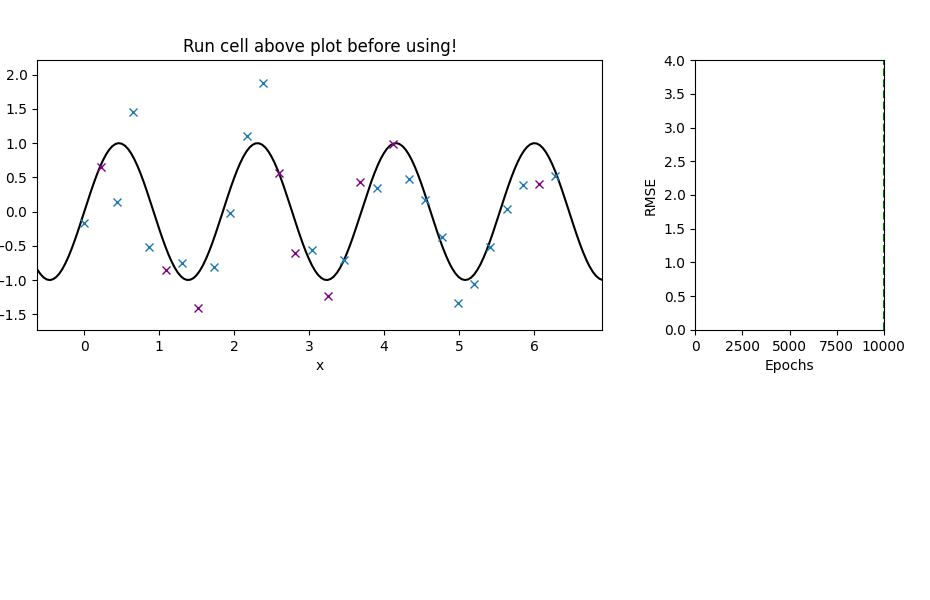

In [5]:
# Define the prediction locations
# (note that these are different from the locations where we observed our data)
x_pred = np.linspace(-1, 2*np.pi+1, 200)

# Function that normalizes data
def norm_x(x, **kwargs):
    return (x - kwargs['mean']) / kwargs['std']

# Function that creates a NN
def create_NN(**kwargs):
    return MLPRegressor(solver='sgd', hidden_layer_sizes=(kwargs['neurons'],kwargs['neurons']), activation=kwargs['activation'], batch_size = kwargs['batch_size'])

# Function that trains a given NN for a given number of epochs
def NN_train(neural_network, x, t, **kwargs):
    x = norm_x(x, **kwargs) # Normalize data
    x = x.reshape(-1, 1)    # Reshape inputs, as it expects a Matrix

    # Run a number of epochs
    for i in range(kwargs['epochs_per_block']):
        neural_network.partial_fit(x, t)

    return neural_network, neural_network.loss_curve_

# Function that returns predictions from a given NN model
def NN_pred(network, x_pred, **kwargs):
    x_pred = norm_x(x_pred, **kwargs) # Normalize data
    return network.predict(x_pred.reshape(-1,1))

plot1 = neuralnetplotter(f_data, f_truth, create_NN, NN_train, NN_pred, x_pred, title=r'Run cell above plot before using!')
plot1.add_sliders('neurons', valmax=20, valinit=3)
plot1.add_buttons('truth', 'seed', 'rerun')
# plot1.add_radiobuttons('activation')
plot1.show()


As you have noticed, using very few neurons is not enough for the network to learn the complexity of the dataset.

# Early stopping

Choosing a high number of neurons increases the number of parameters and slows down training. In addition, it can make the model too flexible and lead to overfitting. Run the model below, and afterward, select the model you think best fits the data. At which epoch do you find the best model?



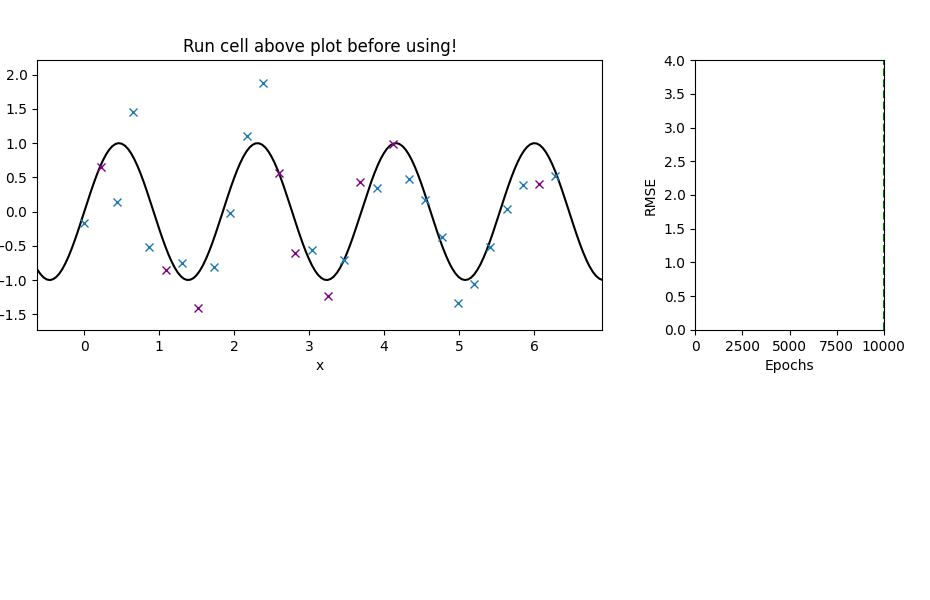

In [6]:
plot1 = neuralnetplotter(f_data, f_truth, create_NN, NN_train, NN_pred, x_pred, title=r'Run cell above plot before using!')
plot1.defaults['neurons']['valinit'] = 20
plot1.defaults['N']['valinit'] = 40
plot1.defaults['val_pct']['valinit'] = 60
plot1.defaults['batch_size']['valinit'] = 2
plot1.defaults['epochs']['valinit'] = 12000
plot1.seed = 4
plot1.add_sliders('cur_model')
plot1.add_buttons('truth', 'rerun')
plot1.show()

It is possible to train a neural network for a long time, and selecting one with a low validation error. An alternative, known as early stopping, uses the indication that the validation loss increases for a number of epochs as a stopping sign to halt training.

The true error is computed since the underlying model is known here. The validation error aims to approximate this true error, and in practice should be used to find the best model. The more data available, the more the training loss approximates the true loss. In the case plotted above, the minimum of the validation loss coincides with the minimum of the true loss.

## Manual model selection
In the previous notebook, you have seen how weight decay can be used to prevent overfitting by adding an additional term to the loss function:
$$\tilde{L} = L + \dfrac{\lambda}{2} \mathbf{w}^T \mathbf{w}.$$

This could also be used for neural networks, however, here we will focus on the impact of the number of trainable parameters and the number of samples on overfitting, being able to go back to different models during training.

Train a number of different neural networks with different settings in the following plot. Also notice the influence of the activation functions for the hidden nodes.

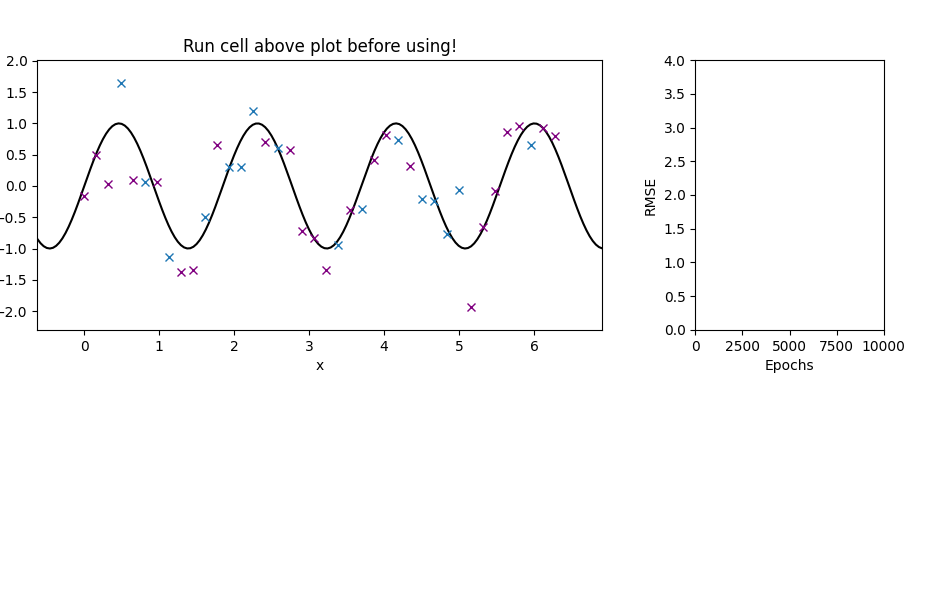

In [7]:
plot1 = neuralnetplotter(f_data, f_truth, create_NN, NN_train, NN_pred, x_pred, title=r'Run cell above plot before using!')
plot1.add_sliders('freq', 'neurons', 'N', 'cur_model', 'val_pct')
plot1.add_buttons('truth', 'seed', 'rerun')
plot1.add_radiobuttons('activation')
plot1.show()

Train a number of different neural networks with different settings, and try to understand what the influence of all the sliders is.
* Is the model with the lowest validation error always the model you think fits best?
* In practical situations when dealing with multiple in and outputs, it is often difficult to visualize the plot on the left for the full space. Can you recognize when a model is underfit based only on the loss plot?
* For a well-trained flexible model with a large training size (N) the errors usually converge to a specific value. What is this value and why does this happen? What happens when the training error is below this value when using a small training size (N)?



For a 2D demonstration that includes classification you can check out the tensorflow playground with 2 dimensional data:  [https://playground.tensorflow.org/](https://playground.tensorflow.org/)

# Wrap-up
In these lectures you have seen how a non-parametric model, namely k-nearest neighbours, works and learned about the bias-variance trade-off. Linear regression was shown as a parametric model that is linear to its parameters and has a closed form solution. Ridge regression has been introduced to prevent overfitting in a stochastic gradient descent setting. In this final notebook, we explored a model with a nonlinear relation with its parameters.
You now understand the underlying principles of almost all machine learning types, as well as how to notice underfit and overfit models.